In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)
set.seed(100)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

## Rock Physical Properties for Rock Type Classification 
**DSCI 100 Project Final Report  
Group 4: Naijide Anwaer, Maggie Ruan, Yun Xing    
Date: December 05, 2021**

## Introduction 

The project provides an overview of the rock petrophysical data process by introducing the rock properties database, illustrating the methodology for data analysis and classification prediction and discussing the outcome.

The Canadian Rock Physical Property Database (CRPPD) includes rock petrophysical measurements on over 20,000 observations collected during the last 40 years (Enkin, 2018). The rock measurements available in this database are density, porosity, resistivity etc. Geographically, observations are categorized into different sample types including outcrop, subcrop, hand sample, and borehole sample. Geologically, observations are categorized into different rock types including igneous, sedimentary, and metamorphic, the three fundamental rock types (American Museum of Natural History, n.d.).

The group intends to study the relationship between the rock petrophysical measurements and the three fundamental rock types, and to answer a classification problem: given the physical properties data of the rock, whether it will be igneous, sedimentary, or metamorphic.

Our classifier model will be useful in the situation where the physical property data are available while the rock type is unclassified. An example of this will be in diamond drillholes (sample type: Borehole), where not all the rock core in the borehole are brought up to the surface for visual examination. As a result, the group decided to perform the data analysis with the focus on data categorized under the sample type borehole.


## Methods

### Data importing
The preliminary data are obtained as a zip file from the Government of Canada, Natural Resources Canada website. Upon unzipping the file and bringing the original excel file into Jupiter notebook for R processing, the group noticed that R encountered a runtime error.

Indicated by read_* documentation, the column type will be imputed from the first 1000 rows on the input file. As the top 1000 data in this excel mostly contains NULL values, R automatically assigned “col_logical” as the column type for most of the columns. However, this column type conflicts with the majority of the other observations, which contain numerical values.

To solve this issue, the group decides to sort the observations in excel before importing them into Jupiter. We relocated the columns with no missing data to the top of the file, save it as a CSV file and upload it to GitHub. R successfully created columns with the proper type “col_double” and no error was thrown. The following code demonstrates the steps of data import:


In [2]:
url <- "https://raw.githubusercontent.com/yxing6/DSCI_100_Project_Group4/main/data/of_8460_database.csv"
rock_data_raw <- read_csv(url)

Parsed with column specification:
cols(
  .default = col_character(),
  `Date Mapped (yyyy/mm/dd) *` = col_double(),
  `Lat Deg` = col_double(),
  `Long Deg` = col_double(),
  `UTM zone` = col_double(),
  Easting = col_double(),
  Northing = col_double(),
  `Method Precision (m)*` = col_double(),
  `Year *` = col_double(),
  `Lab Date` = col_double(),
  `GRAIN DEN Sample Value [g/cm3]` = col_double(),
  `DRY BULK DEN Sample Value [g/cm3]` = col_double(),
  `SAT BULK DEN Sample Value [g/cm3]` = col_double(),
  `POR Sample Value [%]` = col_double(),
  `MS Sample Value [SI A/m / A/m]` = col_double(),
  `NRM Sample Value [A/m]` = col_double(),
  `KN50 Sample Value` = col_double(),
  `Local Field [uT]` = col_double(),
  KN = col_double(),
  `RES Sample Value [Ohm.m]` = col_double(),
  `CHG Sample Value [ms]` = col_double()
)

See spec(...) for full column specifications.



### Data cleaning and wrangling

The original database contains 84 columns. Out of which, we selected 8 columns:

`sample_type`: the location where the sample is collected from. Categorized to three group 
- “Borehole”: samples collected from underground in a form of diamond drill core,  
- “Outcrop”: samples collected from exposed rock on earth surface, and   
- “Subcrop”: samples collected from exposed rock underground.  

`lithology`: physical characteristics of a rock. Categorized as   
- Igneous
- Sedimentary
- Metamorphic

`Density`: mass per unit volume [g/cm³]

`Porosity`: amount of empty spaces in a material as a fraction of the total volume [%]

`MS`: Magnetic Susceptibility, how strong a material can be magnetized under the influence of an external magnetic field [A/m]

`NRM`: natural remanent magnetization.the permanent magnetism of a rock [A/m]

`RES`: electric resistivity, how strongly a material resist electrical current [Ohm.m]

`chargeability` how well a material can hold electrical charge [ms]

At this point, we filter sample_type that is equal to “Borehole” as we discussed in the introduction and filter out “Other” in lithology, keeping three distinctive categories: “Igneous”, “Metamorphic” and “Sedimentary” for further analysis. Table 1 contains the all rock physical properties observations that we will work on in this project. 

The following codes demonstrate the steps of data cleaning and wrangling into a tidy format:


In [4]:
borehole_data_raw <- rock_data_raw %>% 
    select("Location Type *", "MIRA Master Litho 1", "GRAIN DEN Sample Value [g/cm3]",
           "POR Sample Value [%]","MS Sample Value [SI A/m / A/m]",
           "NRM Sample Value [A/m]","RES Sample Value [Ohm.m]","CHG Sample Value [ms]") %>%
    rename("sample_type" = "Location Type *",
          "lithology" = "MIRA Master Litho 1",
           "density" = "GRAIN DEN Sample Value [g/cm3]",
           "porosity" = "POR Sample Value [%]",
           "MS" = "MS Sample Value [SI A/m / A/m]",
           "NRM" = "NRM Sample Value [A/m]",
           "RES" = "RES Sample Value [Ohm.m]",
           "chargeability" = "CHG Sample Value [ms]") %>%
    filter(lithology != "Other", sample_type == "Borehole") %>%
    mutate(sample_type = as_factor(sample_type), lithology = as_factor(lithology)) %>%
    select(-sample_type) 
    
borehole_data_raw

lithology   density porosity MS      NRM   RES    chargeability
1    Igneous     2.931   0.41     0.00118 0.029   7960 46.4         
2    Igneous     2.770   0.28     0.07900 4.810 135000 19.5         
3    Igneous     2.754   0.28     0.01260 0.352  51800  1.6         
⋮    ⋮           ⋮       ⋮        ⋮       ⋮     ⋮      ⋮            
1402 Metamorphic 2.665   0.08         NA    NA   91800  3.868       
1403 Metamorphic 2.641   0.09         NA    NA   67800  1.388       
1404 Metamorphic 2.811   0.36     0.0739  5.72  437000 12.850

*Table 1. Table of all rock physical properties observations.*

### Data splitting

The group split the data into training and testing sets. By only using the training set, we calculated by lithology 
- the number of observations and the observation proportions (See Table 2).
- the mean of each physical property (See Table 3). 


In [5]:
set.seed(100)
borehole_data_split <- initial_split(borehole_data_raw, prop = 0.75, strata = lithology)
data_train <- training(borehole_data_split)
data_test <- testing(borehole_data_split)

data_proportions <- data_train %>%
    group_by(lithology) %>%
    summarize(n = n()) %>%
    mutate(percent = 100 * n / nrow(data_train))
data_proportions

`summarise()` ungrouping output (override with `.groups` argument)



lithology   n   percent 
1 Igneous     255 24.19355
2 Metamorphic 640 60.72106
3 Sedimentary 159 15.08539

*Table 2. Table of the observation numbers and observation proportions.*

In [6]:
data_summary <- data_train %>%
    group_by(lithology) %>%
    summarize(across(density:chargeability, mean, na.rm = TRUE)) %>%
    rename(
        "lithology" = "lithology",
        "mean_Density[g/cm3]" = "density",
        "mean_Porosity[%]" = "porosity",
        "mean_MS[m3/kg]" = "MS",
        "mean_NRM[A/m]" = "NRM",
        "mean_RES[Ohm.m]" = "RES",
        "mean_Chargeability[ms]" = "chargeability")
data_summary

`summarise()` ungrouping output (override with `.groups` argument)



lithology   mean_Density[g/cm3] mean_Porosity[%] mean_MS[m3/kg] mean_NRM[A/m]
1 Igneous     2.807734            2.2347036        0.0233543975   1.49063660   
2 Metamorphic 2.769775            0.5756289        0.0017545455   0.43549625   
3 Sedimentary 2.657881            6.5751572        0.0001492725   0.01513443   
  mean_RES[Ohm.m] mean_Chargeability[ms]
1 98201.207       11.658528             
2  8809.530        6.045462             
3  3816.684        3.493981

*Table 3. Table of the mean value for each predictor by lithology factors.*

In Table 2, we observe some slight unbalance in the number of observations in each lithology factor; however, it is not necessary to perform `up_sample` within this dataset.   
We further compute the VMR(variance-to-mean ratio) to see if we need to perform log transformation for any of the predictors (See Table 4). 

In [7]:
data_var <- data_train %>%
    group_by(lithology) %>%
    summarize(across(density:chargeability, var, na.rm = TRUE))

VMR <- cbind(data_summary[1], round(data_var[2:7] / data_summary[2:7], 3)) %>%
    rename(
        "lithology" = "lithology",
        "VMR_Density" = "density",
        "VMR_Porosity" = "porosity",
        "VMR_MS" = "MS",
        "VMR_NRM" = "NRM",
        "VMR_RES" = "RES",
        "VMR_Chargeability" = "chargeability")
VMR 

`summarise()` ungrouping output (override with `.groups` argument)



lithology   VMR_Density VMR_Porosity VMR_MS VMR_NRM VMR_RES    
1 Igneous     0.017       5.693        0.140  10.286  15837777.96
2 Metamorphic 0.003       2.670        0.027  50.566    151421.38
3 Sedimentary 0.001       3.127        0.006   0.339     13054.65
  VMR_Chargeability
1 21.883           
2 26.267           
3  2.491

*Table 4. Table of the VMR(variance-to-mean ratio) for each predictor by lithology factors.*

According to Table 4, the distribution within physical properties is quite large. In order to make highly skewed distributions less skewed, we performed the log transform which is valuable both for making patterns in the data more interpretable and easier to be visualized. **?for helping to meet the assumptions of inferential statistics?** 
We also removed all the observations containing NA values in order to perform the log transformation. See Table 5 for log transformed training data.


In [8]:
data_train_log <- data_train %>%
    na.omit()%>%
    mutate(Density_log = log(density),
            Porosity_log = log(porosity), 
            NRM_log = log(NRM), 
            RES_log = log(RES), 
            Char_log = log(chargeability),
            MS_log = log(abs(MS))) %>%
    select("lithology","Density_log", "Porosity_log", "NRM_log", "RES_log", "Char_log","MS_log")
data_train_log 

lithology   Density_log Porosity_log NRM_log   RES_log   Char_log  
1   Igneous     1.075344    -0.8915981   -3.540459  8.982184 3.8372995 
2   Igneous     1.018847    -1.2729657    1.570697 11.813030 2.9704145 
3   Igneous     1.013054    -1.2729657   -1.044124 10.855145 0.4700036 
⋮   ⋮           ⋮           ⋮            ⋮         ⋮         ⋮         
917 Metamorphic 0.9794533   -1.203973    -7.137168 10.081634 0.14755756
918 Metamorphic 0.9783261   -1.078810    -8.727914  9.830917 0.01488861
919 Metamorphic 1.0335403   -1.021651     1.743969 12.987688 2.55334381
    MS_log    
1   -6.742241 
2   -2.538307 
3   -4.374058 
⋮   ⋮         
917  -9.340449
918 -11.858237
919  -2.605042

*Table 5. Table of the log-transformed training data.*

### Data visualization for preliminary data analysis

By calling the ggpairs() function, we are able to obtain a scatterplot matrix containing valuable information. Observations for igneous rock are colored in red, sedimentary rock in blue, and metamorphic rock in green.  

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



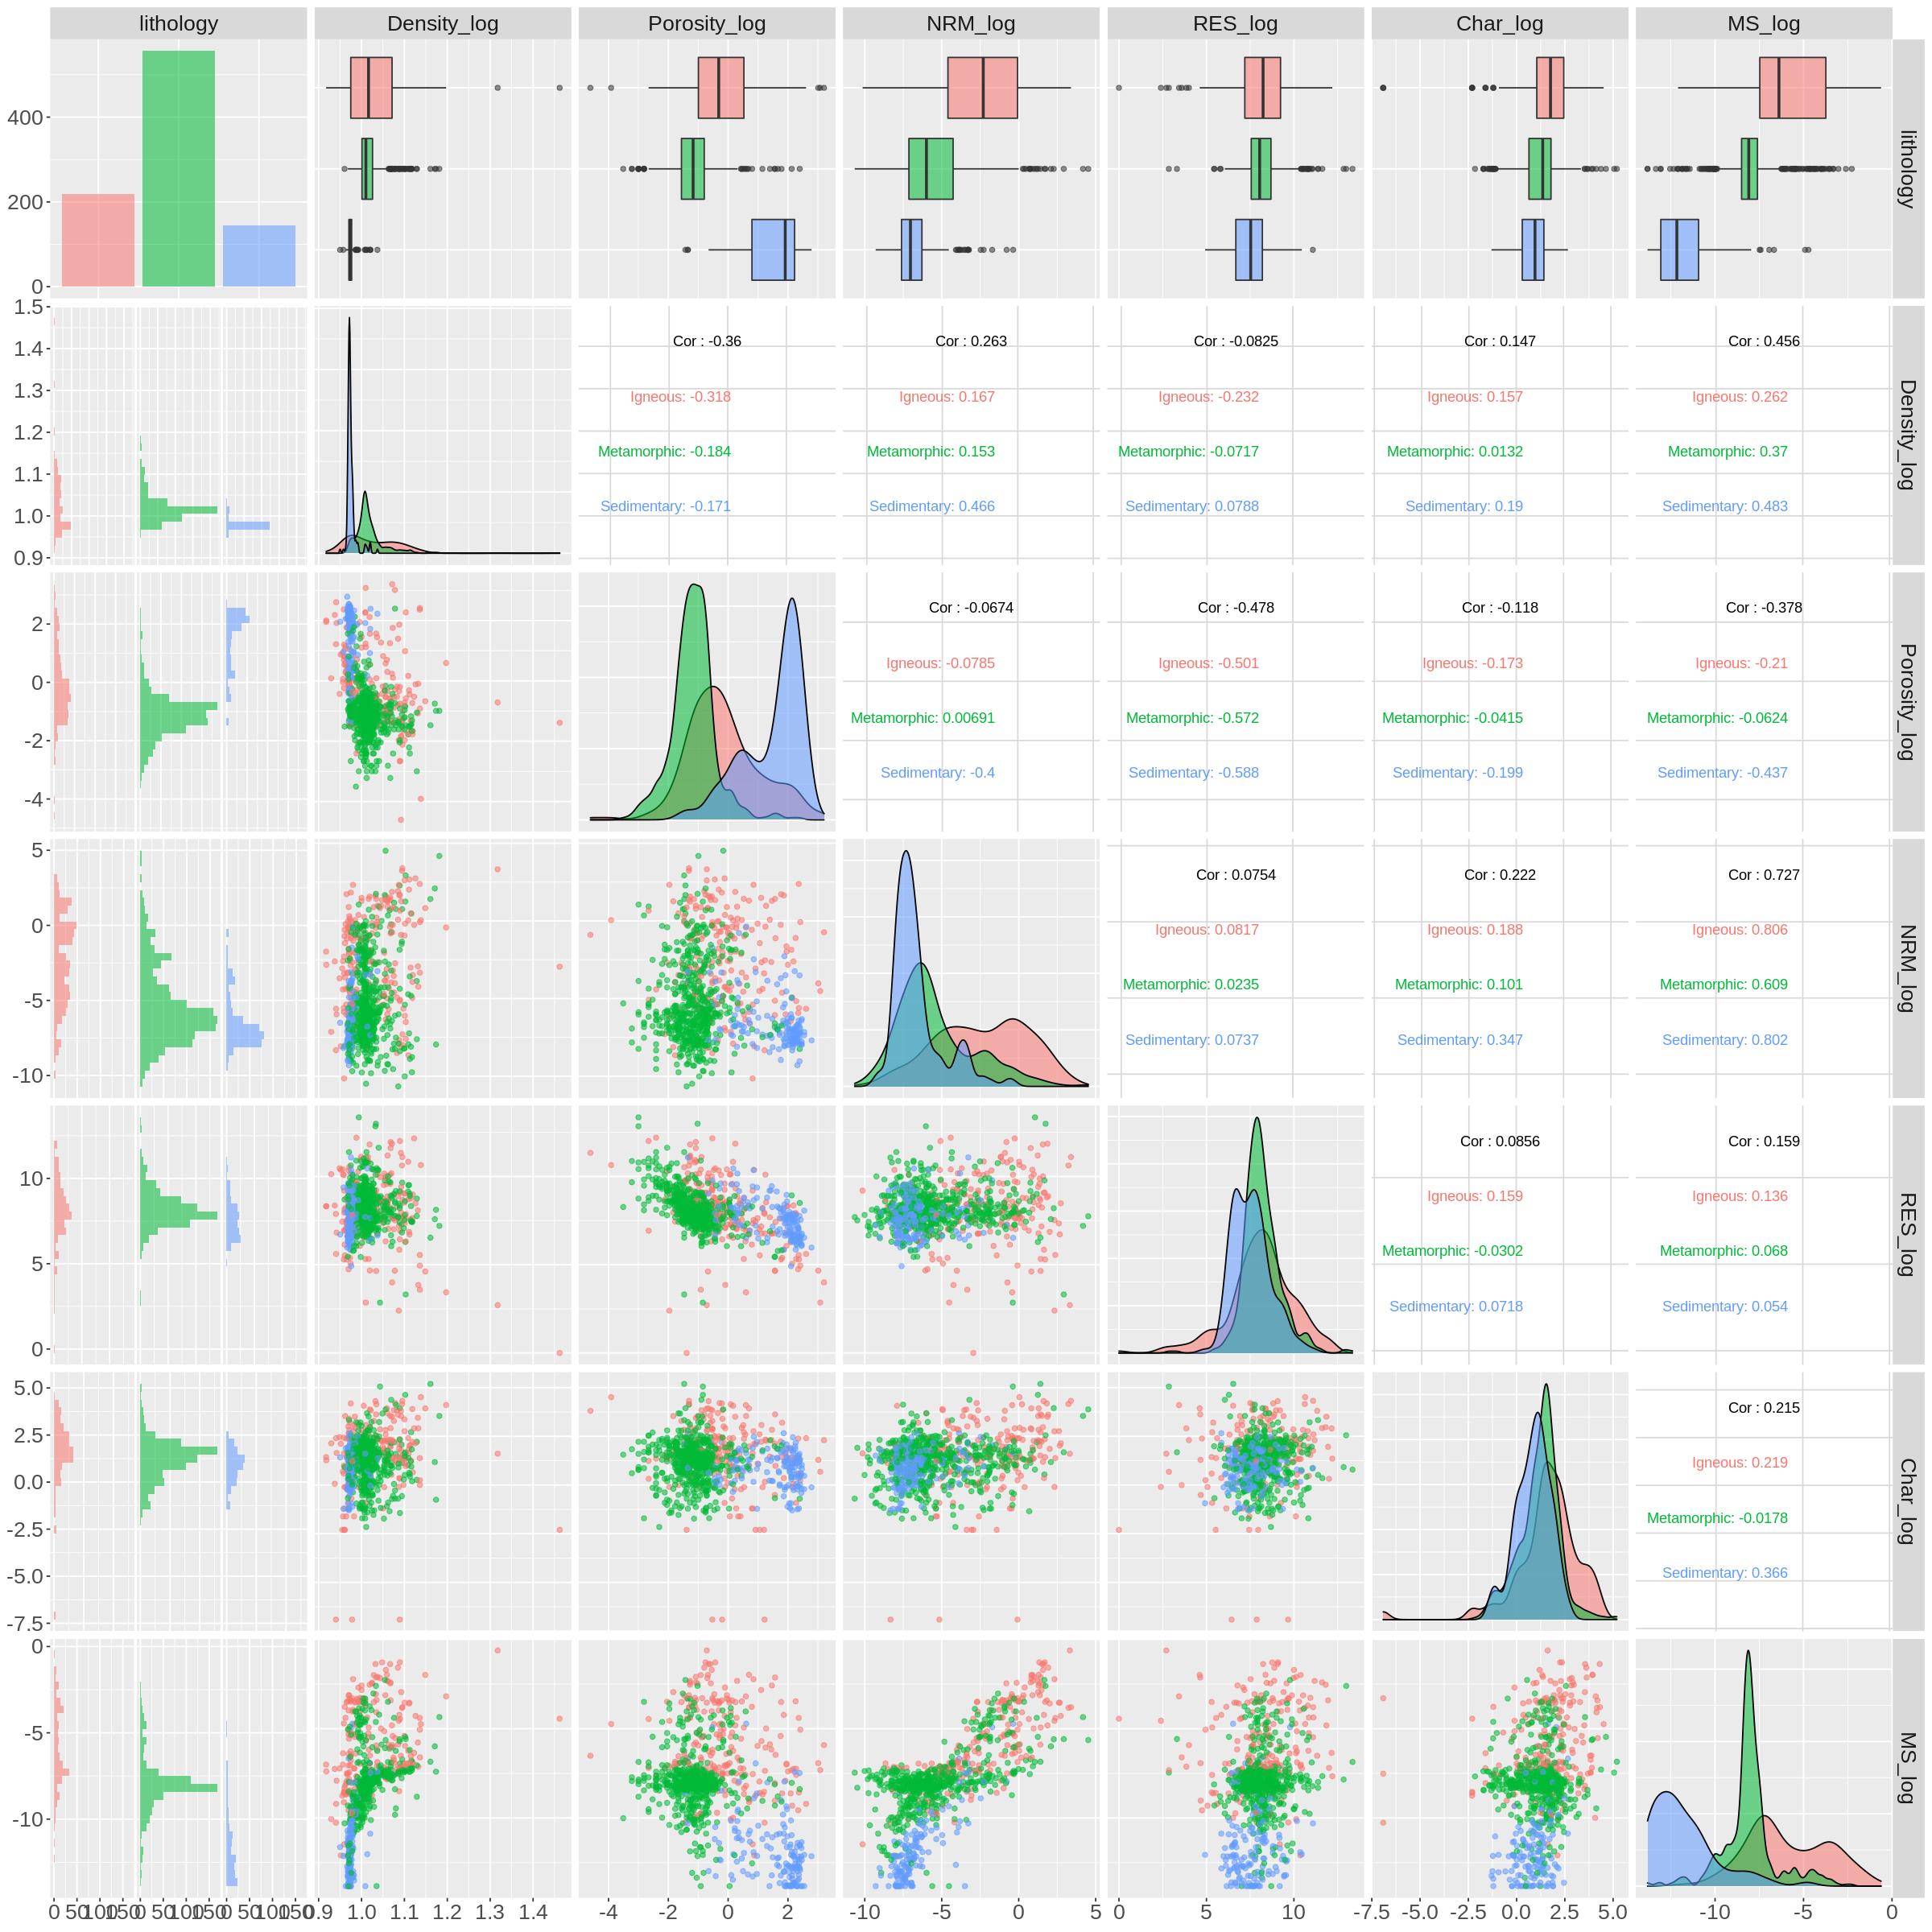

In [9]:
options(repr.plot.width = 20, repr.plot.height = 20)

train_pairs <- data_train_log %>%
    ggpairs(aes(colour = lithology, alpha=0.2))+
    theme(text = element_text(size = 20))
train_pairs

*Figure 1. Scatterplot matrix of the relationships between the six predictors by lithology.*

The diagonal line in Figure 1 contains graphs that display the predictor value distributions by lithology factors. Thus, we should choose the predictors that have more distinct density distribution. MS_log, the log transformation value of magnetic susceptibility exhibits such features. 
After carefully examming the scatterplot with MS on the y-axis, porosity would be a potential choice for the x-axis. The MS_log vs. Porosity_log scatterplot indicates that the three factors are well separated into three clusters. Based on this preliminary visualization, we decide to use Magnetic Susceptibility and Porosity as our two preliminary predictors.


**?The variable distribution that is displayed diagonally along with the box plot on the graph suggests that the factors in Lithology have a greater difference in mean when it comes to MS than to other physical properties. ?**

Figure 2 shows the relationship between selected two predictors, MS vs. Porosity by lithology. Predictor values are log transformed and displayed in linear scale.

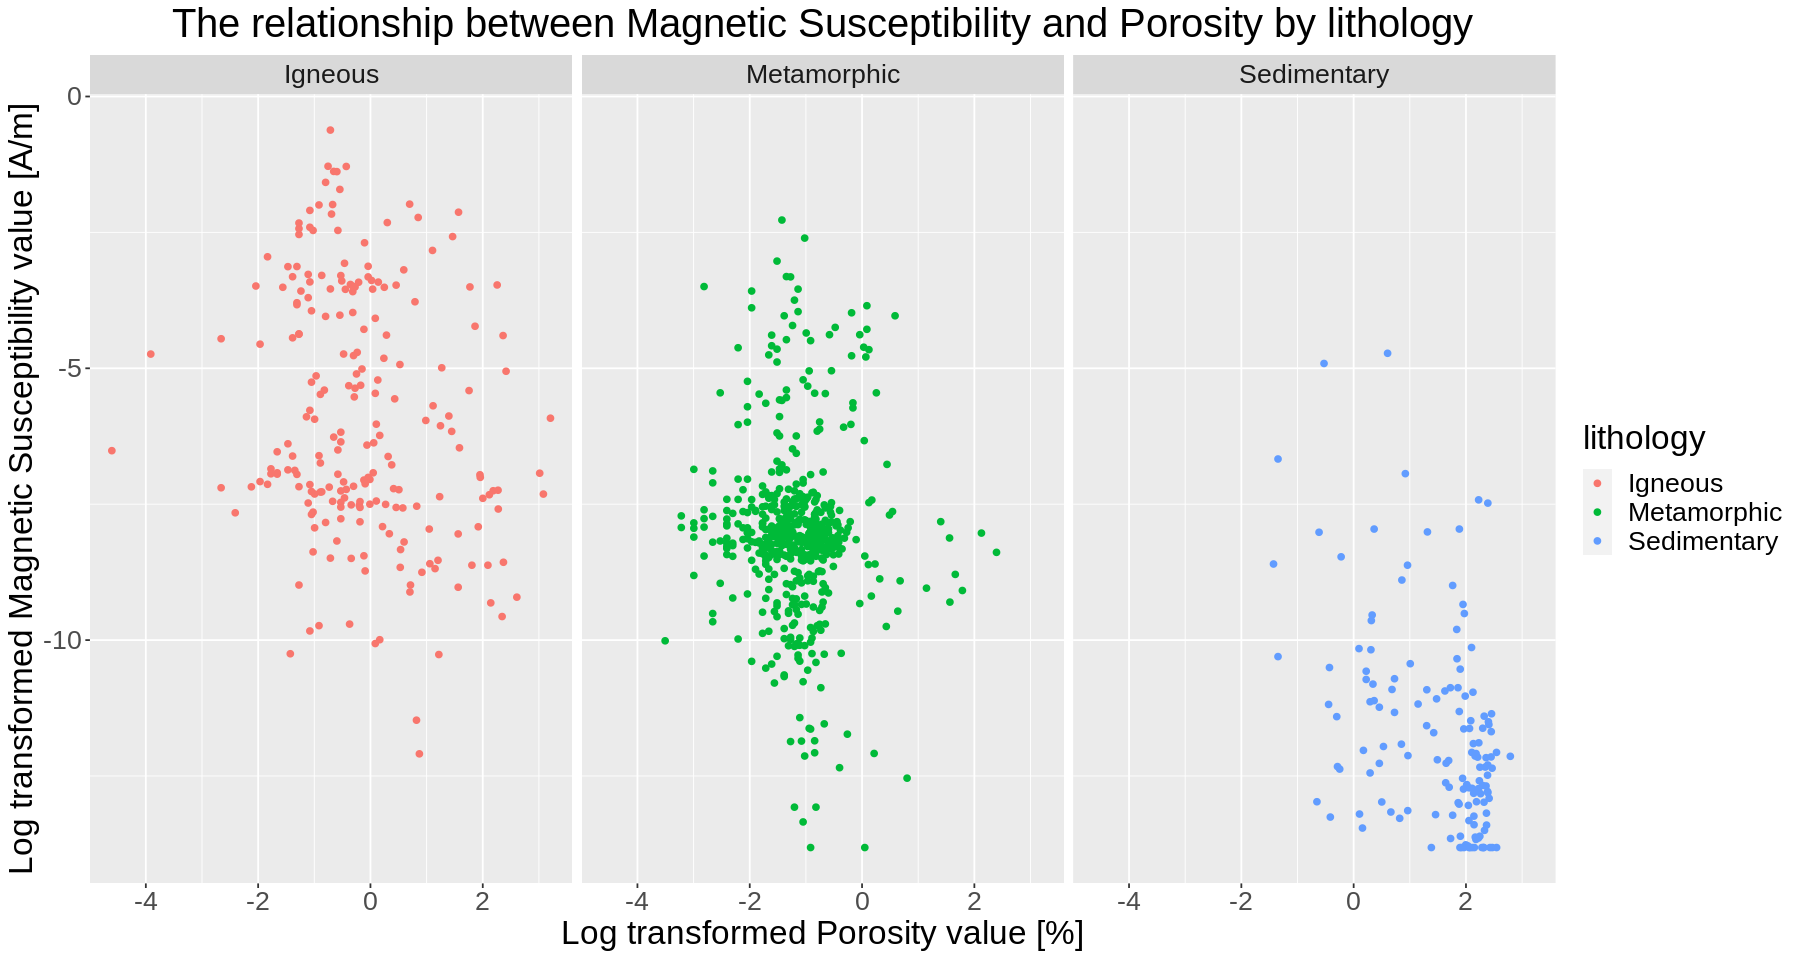

In [15]:
options(repr.plot.width = 15, repr.plot.height = 8)

training_plot <- data_train_log %>%
    ggplot(aes(x = Porosity_log, y = MS_log, color = lithology)) +
    geom_point() +
    facet_grid(. ~ lithology) +
    labs(title = "The relationship between Magnetic Susceptibility and Porosity by lithology", 
         x = "Log transformed Porosity value [%]", y = "Log transformed Magnetic Susceptibility value [A/m]") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
training_plot

*Figure 2: Scatterplot of the relationship between Magnetic Susceptibility and Porosity by lithology.*

### Initial Model from the Preliminary Predictors

The group notices that the set.seed method needs to be called repeatedly to ensure the data is reproducible. Thus, we have set seed at 100 in all the code cells. 

In this section, we performed the classification algorithm in the following sequence: 
1. generate an initial recipe using Porosity_log and MS_log as variables, and log transformed training data as data frame. Within the recipe, we scaled and centered all variables. 
2. use the `vfold_cv` function to split up the log transformed training data for cross validation.
3. create a table contains sequences of value from 1 to 20 to be used in tuning the classifier
4. create a `nearest_neighbors` model specification with `neighbors = tune()`
5. add the recipe and model specification to a `workflow()`, and use the `tune_grid`function to access all values created in step 3. 
6. collect accuracy values of each K into a table in descending order (See Table 6). 
7. draw a line graph to visualize the trend of accuracy vs neighbors (See Figure 3).

*Note in step 3. We have tried using 20+ neighbors in the tuning; however, once after 20, we did not see any significant increase in accuracy. Thus, to achieve effiency and save computational power, we decided to set 20 as the limit in the neighbor tuning. As one weaknesses of k-nn classification is the algorthm gets lower when k gets larger.*

In [16]:
set.seed(100)
options(repr.plot.width = 15, repr.plot.height = 12)

# 1
train_recipe_initial <- recipe(lithology ~ Porosity_log + MS_log, data = data_train_log) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# 2
training_vfold_initial <- vfold_cv(data_train_log, v = 5, strata = lithology)

# 3
k_vals <- tibble(neighbors = seq(1, 20))

# 4
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# 5 
knn_result_initial <- workflow() %>%
    add_recipe(train_recipe_initial) %>%
    add_model(knn_tune) %>%        
    tune_grid(resamples = training_vfold_initial, grid = k_vals) %>%
    collect_metrics()

# 6
accuracies_initial <- knn_result_initial %>% 
    filter(.metric == "accuracy") %>%
    arrange(desc(mean))
accuracies_initial

neighbors .metric  .estimator mean      n std_err    .config
1  17        accuracy multiclass 0.8357529 5 0.01056029 Model17
2  18        accuracy multiclass 0.8357470 5 0.01099696 Model18
3  19        accuracy multiclass 0.8346659 5 0.01226560 Model19
⋮  ⋮         ⋮        ⋮          ⋮         ⋮ ⋮          ⋮      
18 3         accuracy multiclass 0.8085369 5 0.01261623 Model03
19 1         accuracy multiclass 0.7845874 5 0.01343427 Model01
20 2         accuracy multiclass 0.7845874 5 0.01343427 Model02

*Table 6. Table of neighbors and its associated accuracy mean values.*

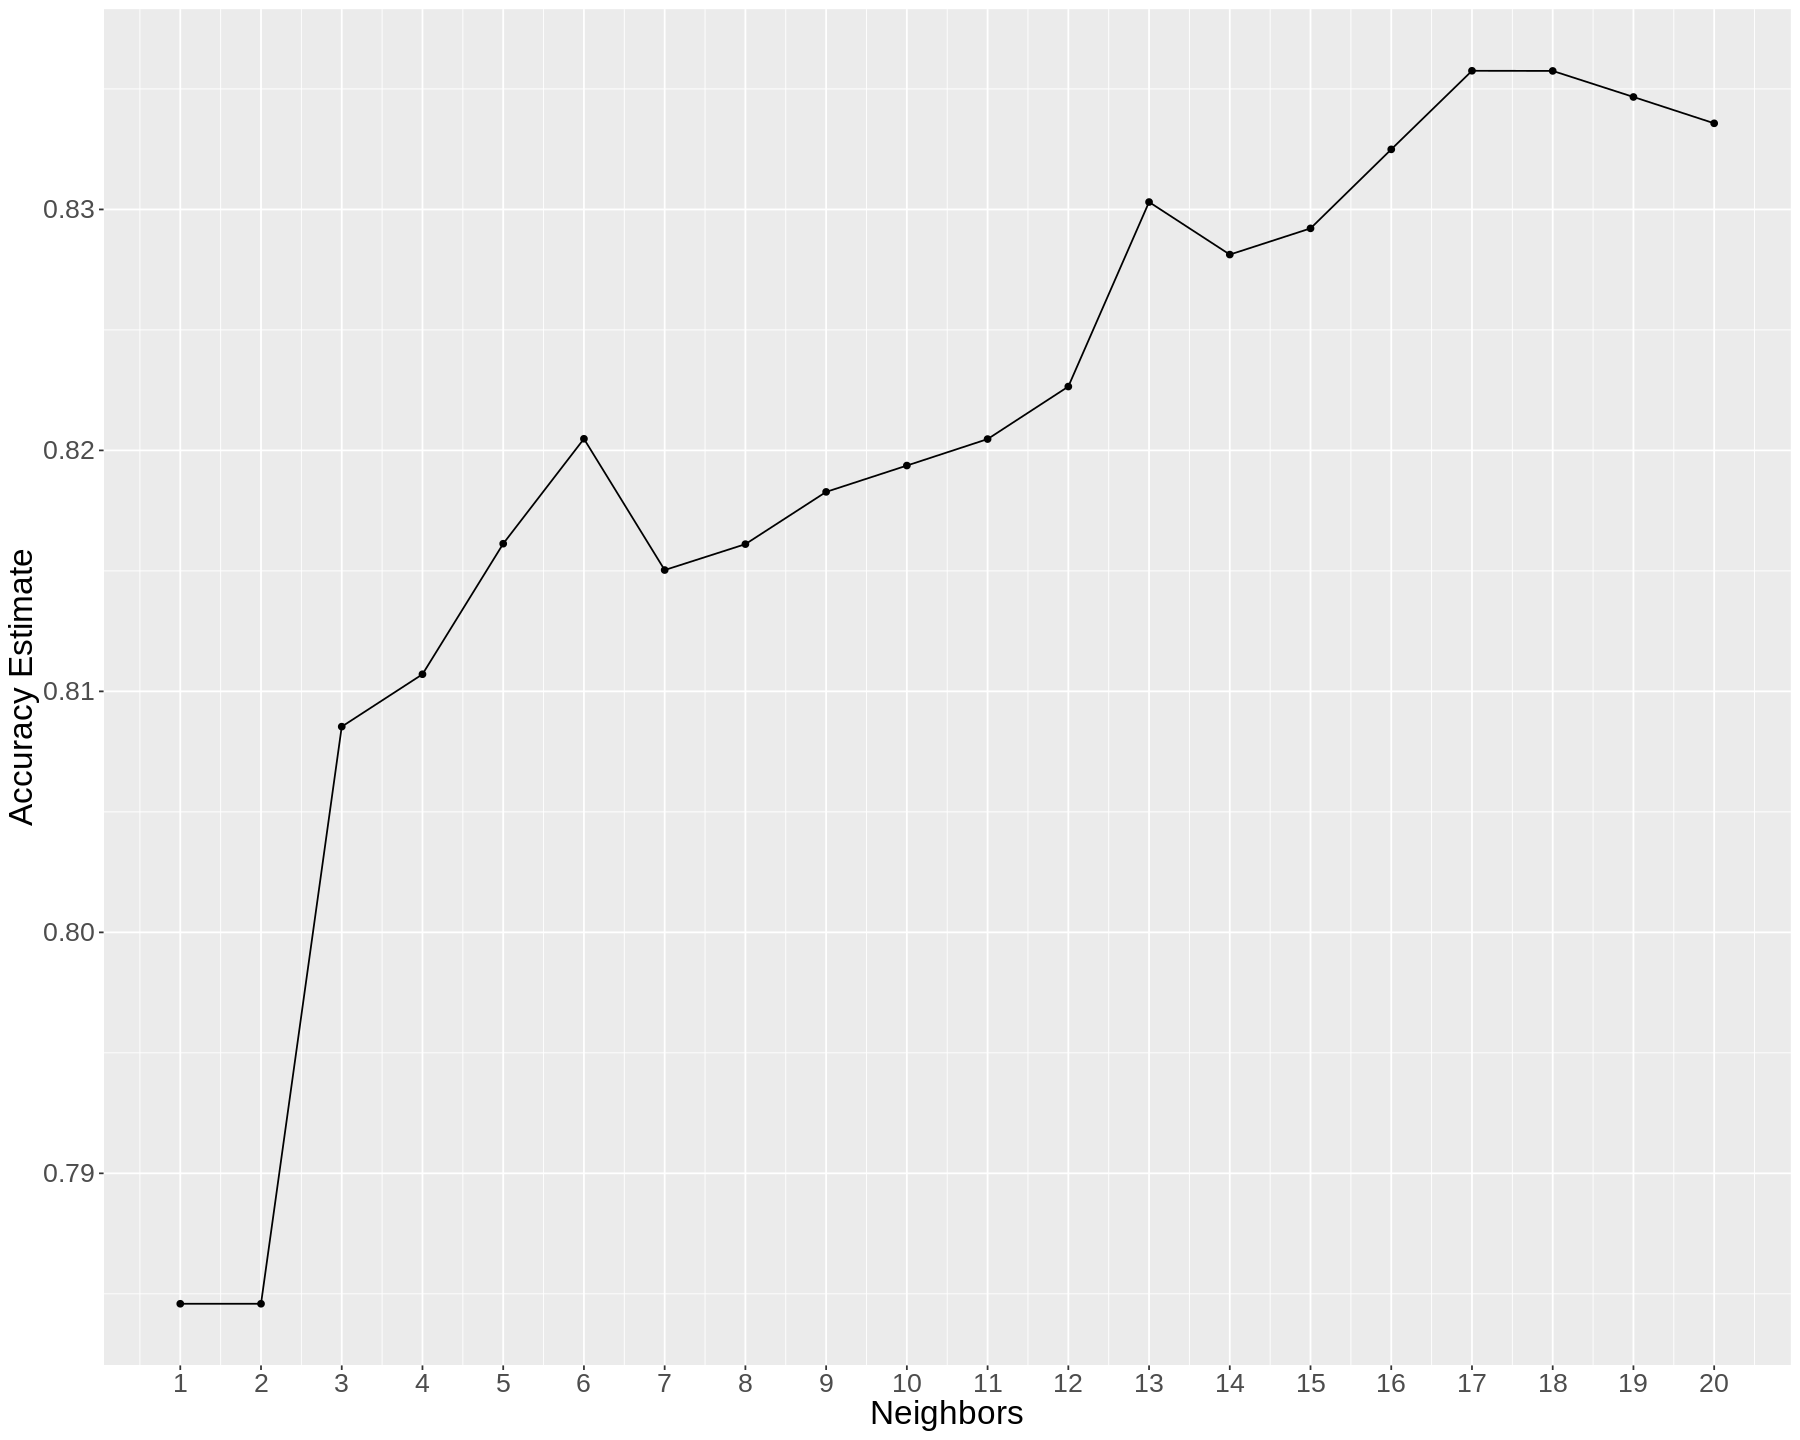

In [17]:
# 7
accuracy_versus_k_initial <- ggplot(accuracies_initial, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 20, by = 1)) + 
    theme(text = element_text(size = 20))
accuracy_versus_k_initial

# 8
top_k_initial <- accuracies_initial %>% 
    head(1) %>%
    select("neighbors") %>%
    pull()

*Figure 3. Line graph of accuracy estimate vs neighbors.*

In [18]:
data_proportions

lithology   n   percent 
1 Igneous     255 24.19355
2 Metamorphic 640 60.72106
3 Sedimentary 159 15.08539

*Table 2. Table of the observation numbers and observation proportions.*

Using Porosity_log and MS_log as predictors, the highest K yields an accuracy of 0.8358. Recall from Table 2, the portion of metamorphic rock in this data set is 60.72%. This estimated accuracy is higher than the majority class proportion in the training data. 

We are confident in our predictor choice; however, we still iteratively performed the above steps with different predictors to confirm that our current choice is the optimal selection. Since magnetic susceptibility is one of the variables that show a great distribution contrast among lithologies, we focus on choosing a second predictor in combination with magnetic susceptibility in this iterative process.   

The code is omitted but the estimated accuracy for each pair of predictors are presented in Table 7.

| Predictor Combination    | Highest estimated accuracy  |
| ----------- | ----------- |
| MS_log + Porosity_log    |   0.8357529 |
| MS_log + Density_log   | 0.7976250       |
| MS_log + NRM_log   | 0.7824016       |
| MS_log + RES_log   | 0.7791521     |
| MS_log + char_log   | 0.7747030       |

<center><i>Table 7. Table of the highest estimated accuracy for different predictor combinations.


### Final Model

As indicated by Table 7, the combination of MS_log and Porosity_log is the optional selection as the predictors. We now go back to the training data and build the final model for this classification project. 

First, instead of removing all observations containing values of NA. We only filter out NA for porosity and magnetic susceptibility and perform the log transfer on these two variables. Table 8 contains the final training table to be used for the model.

In [19]:
data_train_final_log <- data_train %>%
    filter(!is.na(porosity)) %>%
    filter(!is.na(MS)) %>%
    mutate(Porosity_log = log(porosity), 
            MS_log = log(abs(MS))) %>%
    select("lithology","density", "Porosity_log", "MS_log", "NRM", "RES", "chargeability",)
data_train_final_log

lithology   density Porosity_log MS_log     NRM      RES    chargeability
1    Igneous     2.931   -0.8915981   -6.742241  0.029      7960 46.4         
2    Igneous     2.770   -1.2729657   -2.538307  4.810    135000 19.5         
3    Igneous     2.754   -1.2729657   -4.374058  0.352     51800  1.6         
⋮    ⋮           ⋮       ⋮            ⋮          ⋮        ⋮      ⋮            
999  Metamorphic 2.663   -1.203973     -9.340449 0.000795  23900  1.159       
1000 Metamorphic 2.660   -1.078810    -11.858237 0.000162  18600  1.015       
1001 Metamorphic 2.811   -1.021651     -2.605042 5.720000 437000 12.850

*Table 8. Table of the final training data.*

We now perform the classification algorithm in the following sequence again with the final training data: 
1. generate a final recipe using Porosity_log and MS_log as variables, and final training data as data frame. Within the recipe, we scaled and centered all variables. 
2. use the `vfold_cv` function to split up the log transformed training data for cross validation.
3. add the recipe and model specification to a `workflow()`, and use the `tune_grid`function to access all K values created before. 
4. collect accuracy values of each K into a table in descending order (See Table 9). 
5. draw a line graph to visualize the trend of accuracy vs neighbors (See Figure 4).

*note: the sequence of neighbor values and the tuning model specification is not recreated here.*

In [20]:
set.seed(100)
options(repr.plot.width = 15, repr.plot.height = 12)

# 1
train_recipe_final <- recipe(lithology ~ Porosity_log + MS_log, data = data_train_final_log) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# 2
training_vfold_final <- vfold_cv(data_train_final_log, v = 5, strata = lithology)

# 3
knn_result_final <- workflow() %>%
    add_recipe(train_recipe_final) %>%
    add_model(knn_tune) %>%        
    tune_grid(resamples = training_vfold_final, grid = k_vals) %>%
    collect_metrics()

# 4
accuracies_final <- knn_result_final %>% 
    filter(.metric == "accuracy") %>%
    arrange(desc(mean))
accuracies_final

neighbors .metric  .estimator mean      n std_err     .config
1  19        accuracy multiclass 0.8370896 5 0.007044182 Model19
2  18        accuracy multiclass 0.8350696 5 0.008502358 Model18
3  20        accuracy multiclass 0.8340745 5 0.008256008 Model20
⋮  ⋮         ⋮        ⋮          ⋮         ⋮ ⋮           ⋮      
18 4         accuracy multiclass 0.8081135 5 0.008141108 Model04
19 1         accuracy multiclass 0.7891975 5 0.004423912 Model01
20 2         accuracy multiclass 0.7891975 5 0.004423912 Model02

*Table 9. Table of neighbors and its associated accuracy mean values in the final model.*

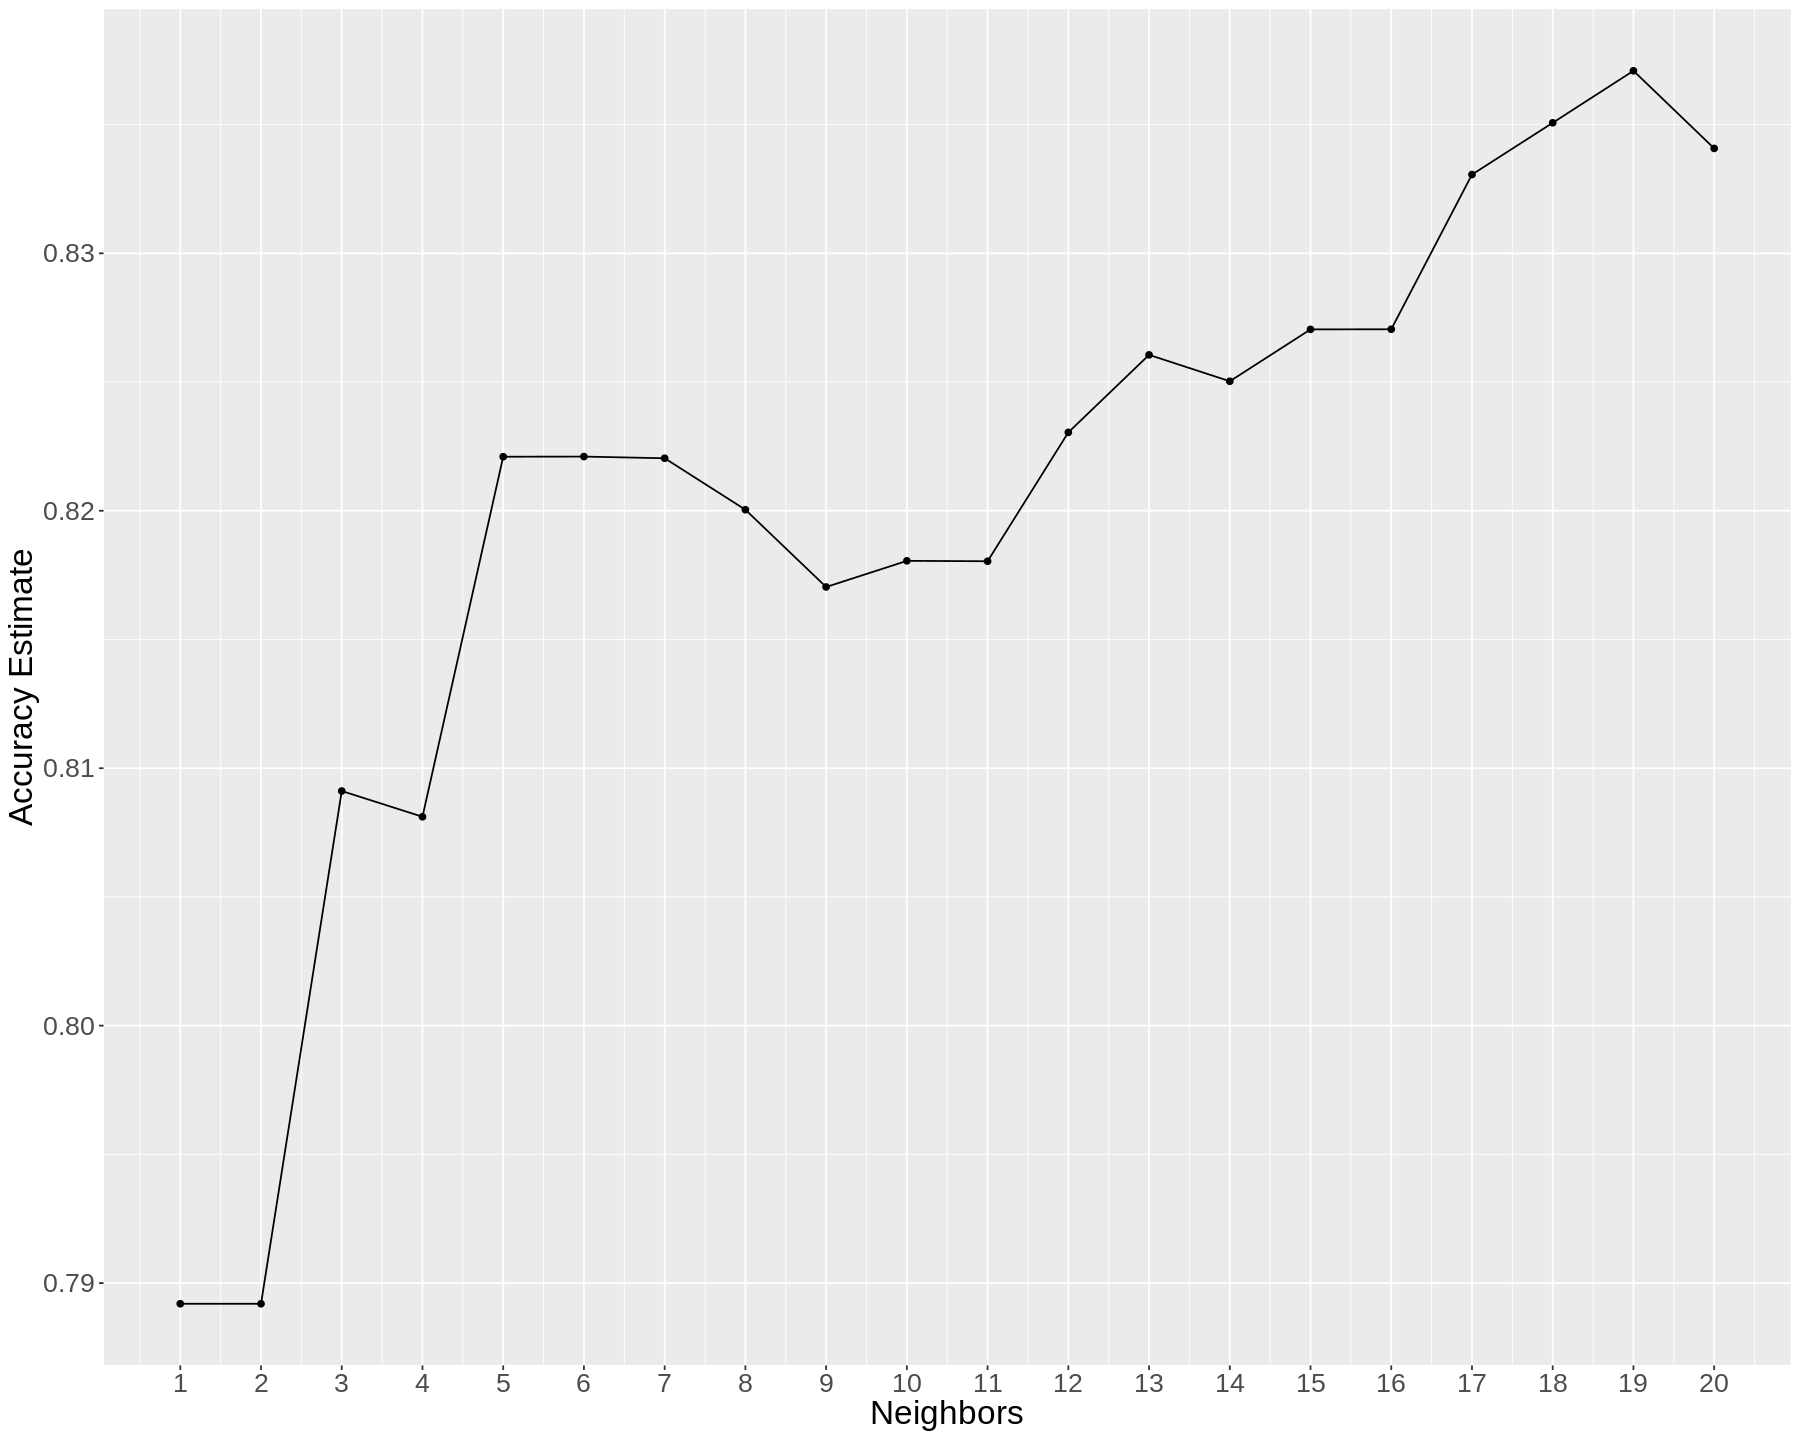

In [21]:
# 5
accuracy_versus_k_final <- ggplot(accuracies_final, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 20, by = 1)) + 
    theme(text = element_text(size = 20))
accuracy_versus_k_final

*Figure 4. Line graph of accuracy estimate vs neighbors.*

After the visualization of all the K-values and the associated accuracy.   

6. select an odd value of K that yields a high accuracy estimate that doesn’t change much if you change K to a nearby value. In this situation, the highest value K = 19 meets the requirement.

We continue the KNN classification algorithm:

7. Make a new model specification for the best K value. 
8. Retrain the classifier using the `fit` function

In [22]:
# 6
top_k_final <- accuracies_final %>% 
    head(1) %>%
    select("neighbors") %>%
    pull()

# 7
knn_final <- nearest_neighbor(weight_func = "rectangular", neighbors = top_k_final) %>%
       set_engine("kknn") %>%
       set_mode("classification")

# 8
rock_model_final <- workflow() %>%
       add_recipe(train_recipe_final) %>%
       add_model(knn_final) %>%
       fit(data = data_train_log)

rock_model_final

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~top_k_final,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1686616
Best kernel: rectangular
Best k: 19

## Model Prediction

We are now ready to test the final model on test data. 
We perform the same data wrangling we did on the test data including remove NA and log transformation for porosity and magnetic susceptibility. See Table 10 for the final testing data.

In [23]:
data_test_log <- data_test %>%
    filter(!is.na(porosity)) %>%
    filter(!is.na(MS)) %>%
    mutate(Porosity_log = log(porosity), 
            MS_log = log(abs(MS))) %>%
    select("lithology","density", "Porosity_log", "MS_log", "NRM", "RES", "chargeability",)
data_test_log

lithology   density Porosity_log MS_log    NRM      RES    chargeability
1   Igneous     2.615   -0.3285041   -9.631935 0.000648  5250   2.5         
2   Igneous     2.804   -1.0788097   -1.725972 2.980000 17200  12.6         
3   Igneous     2.938   -1.0788097   -3.405205 0.384000 26000   6.5         
⋮   ⋮           ⋮       ⋮            ⋮         ⋮        ⋮      ⋮            
330 Metamorphic 2.703    1.406097    -8.645027 0.003240    365 9.200        
331 Metamorphic 2.680   -1.272966    -7.915613 0.006220 110000 0.916        
332 Metamorphic 2.791   -1.832581    -8.691547 0.000401  27100 8.026

*Table 10. Table of the final testing data.*

We predict lithology for the test data set using the `predict` function and combine the prediction with the testing dataset using the `bind_cols` function. In Table 11, the first column contains the predicted lithology from the model, and the second column contains the original lithology label for each observation. 

In [24]:
rock_prediction <- predict(rock_model_final, data_test_log) %>% bind_cols(data_test_log)
rock_prediction

.pred_class lithology   density Porosity_log MS_log    NRM      RES   
1   Metamorphic Igneous     2.615   -0.3285041   -9.631935 0.000648  5250 
2   Igneous     Igneous     2.804   -1.0788097   -1.725972 2.980000 17200 
3   Igneous     Igneous     2.938   -1.0788097   -3.405205 0.384000 26000 
⋮   ⋮           ⋮           ⋮       ⋮            ⋮         ⋮        ⋮     
330 Igneous     Metamorphic 2.703    1.406097    -8.645027 0.003240    365
331 Metamorphic Metamorphic 2.680   -1.272966    -7.915613 0.006220 110000
332 Metamorphic Metamorphic 2.791   -1.832581    -8.691547 0.000401  27100
    chargeability
1    2.5         
2   12.6         
3    6.5         
⋮   ⋮            
330 9.200        
331 0.916        
332 8.026

*Table 11. Table of final prediction for each observation.*

Finally we assess our classifier’s accuracy by using the `metrics` function. (See Table 12).

In [25]:
prediction_accuracy <- rock_prediction %>% 
    metrics(truth = lithology, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
prediction_accuracy

.metric  .estimator .estimate
1 accuracy multiclass 0.8524096

*Table 12. Table of accuracy of the rock physical properties classifier.*

Furthermore, we compute the confusion matrix for the classifier using the `conf_mat` function (See Table 13).  

In [26]:
prediction_confusion <- rock_prediction %>%
             conf_mat(truth = lithology, estimate = .pred_class)
prediction_confusion

             Truth
Prediction    Igneous Metamorphic Sedimentary
  Igneous          45          13           2
  Metamorphic      26         191           4
  Sedimentary       2           2          47

The confusion matrix shows 45 observations were correctly predicted as igneous, 191 were correctly predicted as metamorphic, and 47 were correctly predicted as sedimentary. Therefore, the classifier labeled 45 + 191 + 47 = 283 observations correctly.  With a total of 332 observations in the testing test, the prediction accuracy is 85.24%, which is slightly higher than the estimated accuracy (83.71%).  
We conclude that the current model is a valid and accurate model to predict rock type.   
Figure 5 is a color coded visualization of the prediction on top of the labelled observations. 

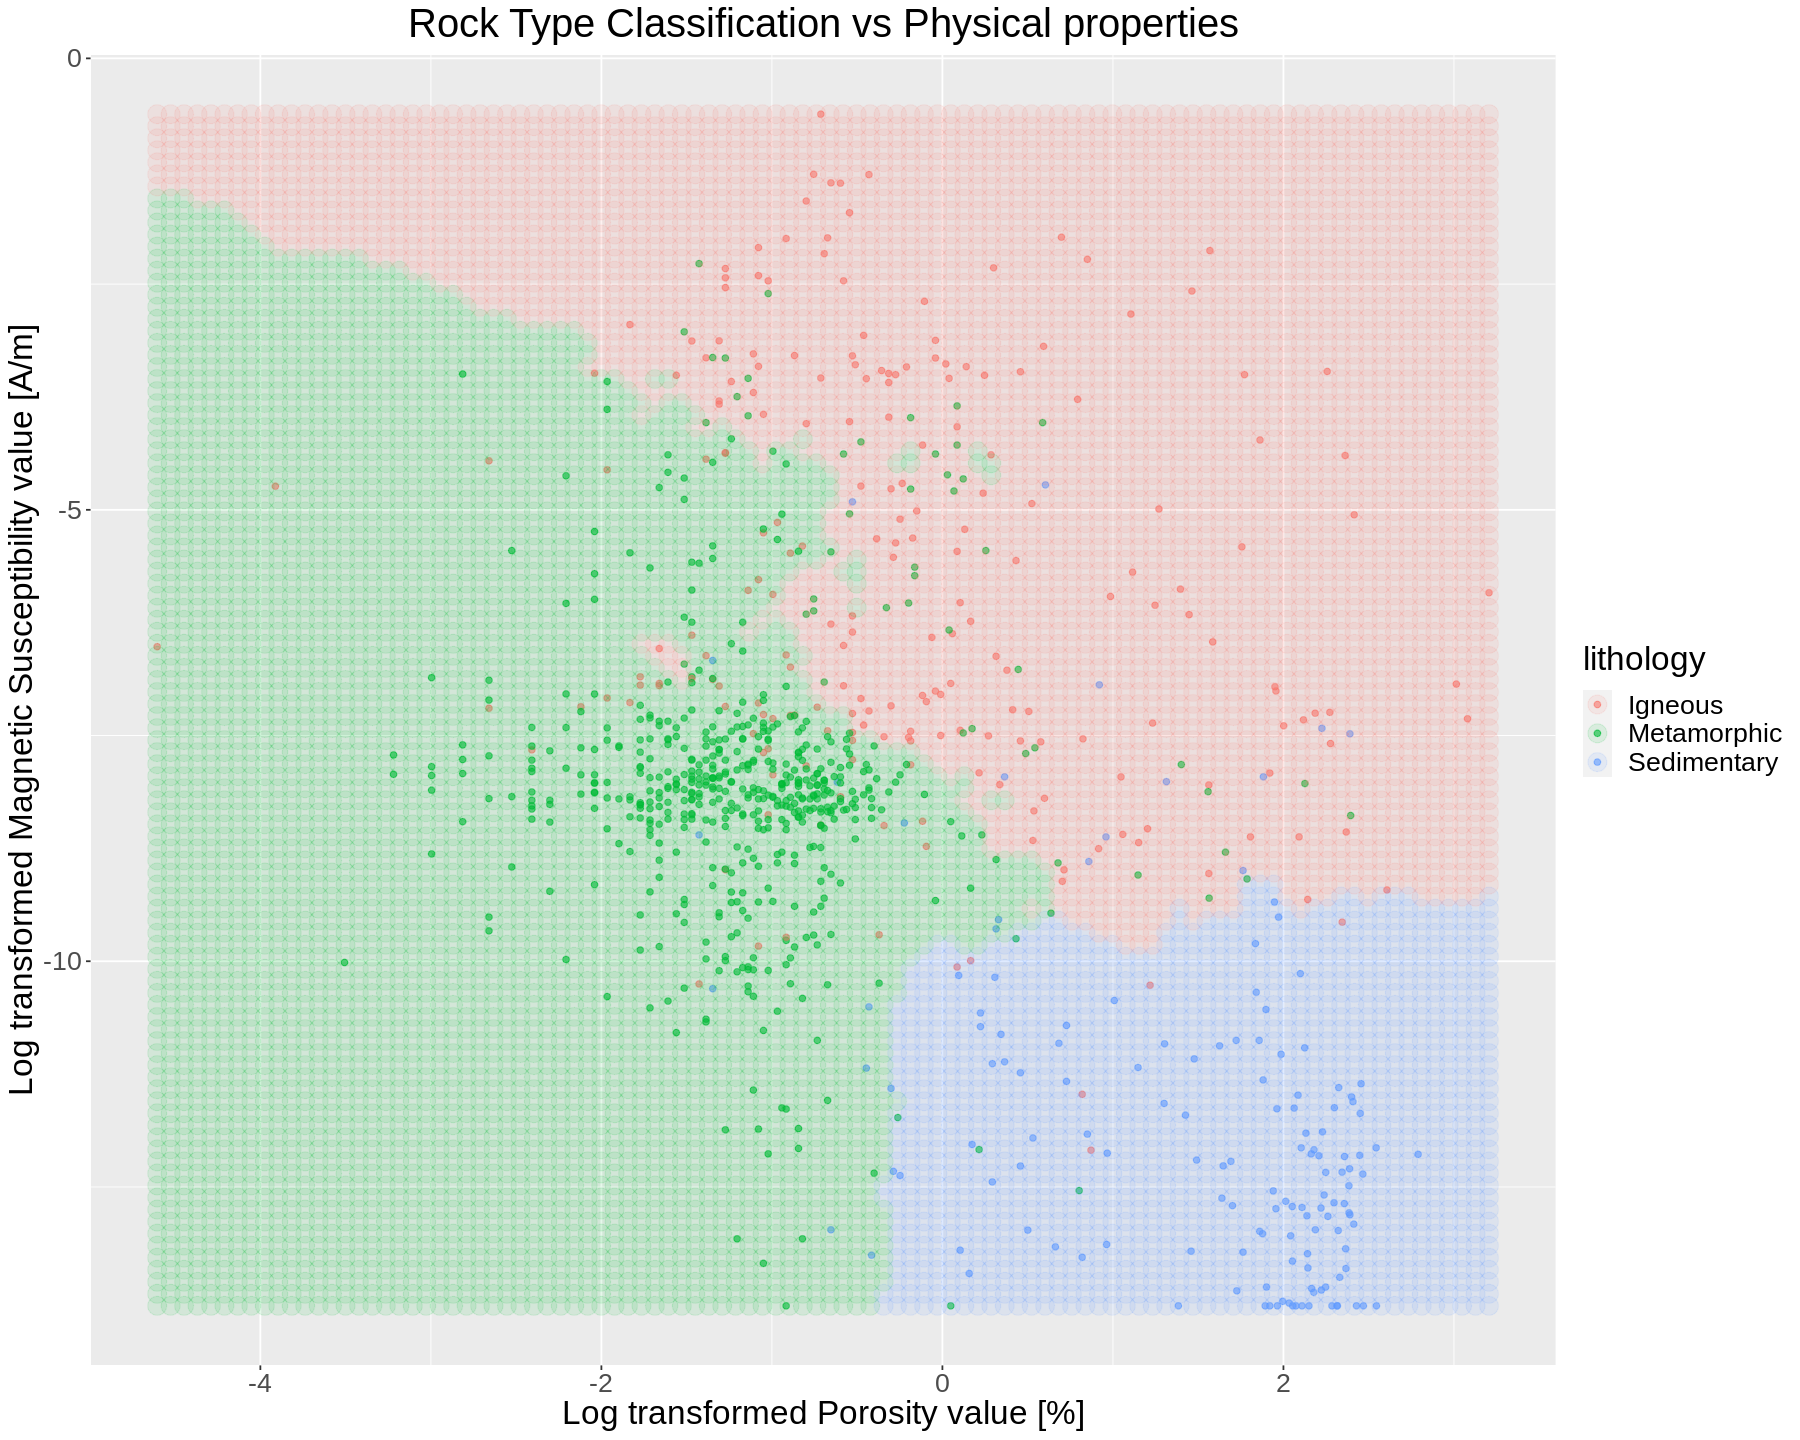

In [27]:
options(repr.plot.width = 15, repr.plot.height = 12)

# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(min(data_train_log$Porosity_log), 
                max(data_train_log$Porosity_log), 
                length.out = 100)
smo_grid <- seq(min(data_train_log$MS_log), 
                max(data_train_log$MS_log),
                length.out = 100)
asgrid <- as_tibble(expand.grid(Porosity_log = are_grid, MS_log = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(rock_model_final, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% rename(lithology = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
    ggplot() +
    geom_point(data = data_train_log,
               mapping = aes(x = Porosity_log, y = MS_log, color = lithology), alpha = 0.6) +
    geom_point(data = prediction_table, 
               mapping = aes(x = Porosity_log, y = MS_log, color = lithology), alpha = 0.1, size = 5) +
    ggtitle("Rock Type Classification vs Physical properties") +
    labs(x = "Log transformed Porosity value [%]", y = "Log transformed Magnetic Susceptibility value [A/m]") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))

wkflw_plot

*Figure 5. Scatter plot of prediction.*

## Discussion

Old  
Through preliminary data visualization we were able to identify the two predictors that could possibly lead to a high accuracy classification model. The two predictors were magnetic susceptibility and porosity. The two predictors produced an optimum k which resulted in neighbors being 19 in the model. With the training model producing an accuracy of 83%, our model on the testing data produced 85% accuracy. These two predictors produced the highest accuracy with our model. More interesting findings include the igneous rock type being the least accurate with our prediction models, and a good portion of it was mistakenly classified as metamorphic.

This was close to what we expected to find, as we have predicted that porosity would be an important factor. We, however, underestimated the importance of magnetic susceptibility and believed resistivity to have such importance. 

Such findings and classification models could assist in creating high accuracy classification in rock types when the physical properties are accessible by suggesting the more important properties to use when building better models.

Such projects could lead to more questions in rock type classification. What causes porosity and magnetic susceptibility to have such a high influence on classification models, and how exactly do they each influence the result? What physical properties to consider when porosity and magnetic susceptibility are not accessible? 


**New**  
Through preliminary data visualization, we first identified two predictors that are suitable for the rock lithology type classification model. The two predictors were magnetic susceptibility and porosity. Using these two predictors, our initial model returned an estimated accuracy of 83.6%. We then iteratively chose other variables as predictors, and confirmed that magnetic susceptibility and porosity were indeed the optimal selection.   
We built the final rock lithology classification model using these two variables as predictors. The estimated model accuracy is 83.7% and with an optimal k value of 19.   
We then used 19 as the number of neighbors, finalized the classification model, and ran the model on test data for validation. The prediction had an accuracy of 85.2%, which agrees with the estimated accuracy. Both values were higher than the proportion of the majority class and we concluded the model as a valid and accurate model for rock lithology type prediction. 

At the initial stage of the project, we were focusing on using porosity and resistivity as two predictors for the model. However, after visualizing the ggpair() graph with color coded by lithology type. We revealed the relationship between porosity and magnetic susceptibility. We initially underestimated the correlation between these two predictors. Nevertheless, we were able to discover the relationship and build our final model using porosity and magnetic susceptibility. The model predicts rock lithology type accurately as expected.   
 
The finding and the classification model can be used to aid the uranium exploration activities in northern Saskatchewan, Canada. In recent decades, geoscientists have been trying to locate high grade uranium in the Athabasca basin (World Nuclear Association, 2021). The Athabasca basin consists of primarily metamorphic and igneous rocks. The basin is also underlyed by a layer of sandstone rocks. All diamond drillholes need to drill through the sandstone layer to reach the basement layers. If the physical property data can be obtained at the same time of the drilling, then geoscientists can use the physical properties and the classification model to determine if the dillhole has passed the sandstone layer and reached the basement layer.   

The current prediction accuracy is 85.2%. Is this accuracy good enough? There should be ongoing discussion with geoscientists about model accuracy and predictor choice. What causes porosity and magnetic susceptibility to have such a high influence on classification models, and how exactly do they each influence the result? What physical properties to consider when porosity and magnetic susceptibility are not accessible? These are the questions this model and its finding could lead to. 
 

### References

American Museum of Natural History. (n.d.). *Three Types of Rock*. Retrieved December 7, 2021, from https://www.amnh.org/exhibitions/permanent/planet-earth/how-do-we-read-the-rocks/three-types. 

Enkin, R.J., (2018). Canadian rock physical property database: First public release. *Geological Survey of Canada*. Open File 8460. 313389. https://doi.org/10.4095/313389

World Nuclear Association. (2020, January). *Uranium in Canada*. Retrieved December 6, 2021, from https://world-nuclear.org/information-library/country-profiles/countries-a-f/canada-uranium.aspx
